
# **Project Title : Seoul Bike Sharing Demand Prediction**





Problem Description
Currently Rental bikes are introduced in many urban cities for the enhancement of mobility comfort. It is important to make the rental bike available and accessible to the public at the right time as it lessens the waiting time. Eventually, providing the city with a stable supply of rental bikes becomes a major concern. The crucial part is the prediction of bike count required at each hour for the stable supply of rental bikes.

## <b> Data Description </b>

### <b> The dataset contains weather information (Temperature, Humidity, Windspeed, Visibility, Dewpoint, Solar radiation, Snowfall, Rainfall), the number of bikes rented per hour and date information.</b>


### <b>Attribute Information: </b>

* ### Date : year-month-day
* ### Rented Bike count - Count of bikes rented at each hour
* ### Hour - Hour of he day
* ### Temperature-Temperature in Celsius
* ### Humidity - %
* ### Windspeed - m/s
* ### Visibility - 10m
* ### Dew point temperature - Celsius
* ### Solar radiation - MJ/m2
* ### Rainfall - mm
* ### Snowfall - cm
* ### Seasons - Winter, Spring, Summer, Autumn
* ### Holiday - Holiday/No holiday
* ### Functional Day - NoFunc(Non Functional Hours), Fun(Functional hours)

In [79]:
!pip install matplotlib 3.5.3

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
ERROR: Could not find a version that satisfies the requirement 3.5.3 (from versions: none)
ERROR: No matching distribution found for 3.5.3


## **Read data**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
sns.set_style('darkgrid')

import matplotlib.pyplot as plt
import chardet
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV, \
GridSearchCV

from sklearn.metrics import classification_report, confusion_matrix, \
accuracy_score, auc, precision_score, recall_score, r2_score

from sklearn.feature_selection import mutual_info_classif

from sklearn.inspection import permutation_importance

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

In [4]:
pd.set_option('max_rows', None)
pd.set_option('max_columns', None)

In [5]:
# Need to detect the encoding

link = '/content/drive/MyDrive/SeoulBikeData.csv'

with open(link, 'rb') as file:
    print(chardet.detect(file.read()))

{'encoding': 'ISO-8859-1', 'confidence': 0.73, 'language': ''}


In [6]:
# Read the data into a dataframe
# copy of 'data' will be used

data = pd.read_csv(link, encoding = 'ISO-8859-1')
data.head(4)

,Date,Rented Bike Count,Hour,Temperature(°C),Humidity(%),Wind speed (m/s),Visibility (10m),Dew point temperature(°C),Solar Radiation (MJ/m2),Rainfall(mm),Snowfall (cm),Seasons,Holiday,Functioning Day
0,01/12/2017,254,0,-5.2,37,2.2,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
1,01/12/2017,204,1,-5.5,38,0.8,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
2,01/12/2017,173,2,-6.0,39,1.0,2000,-17.7,0.0,0.0,0.0,Winter,No Holiday,Yes
3,01/12/2017,107,3,-6.2,40,0.9,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes


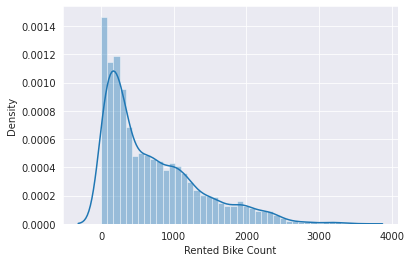

Negative rentals : 0


In [7]:
# Plot the distribution of the target variable

plt.figure()
sns.distplot(a = data['Rented Bike Count'], kde = True)
plt.show()

# Just check if theres any day where bike rent < 0
# Seems sane

print('Negative rentals : {}' .format(data[data['Rented Bike Count'] < 0].shape[0]))

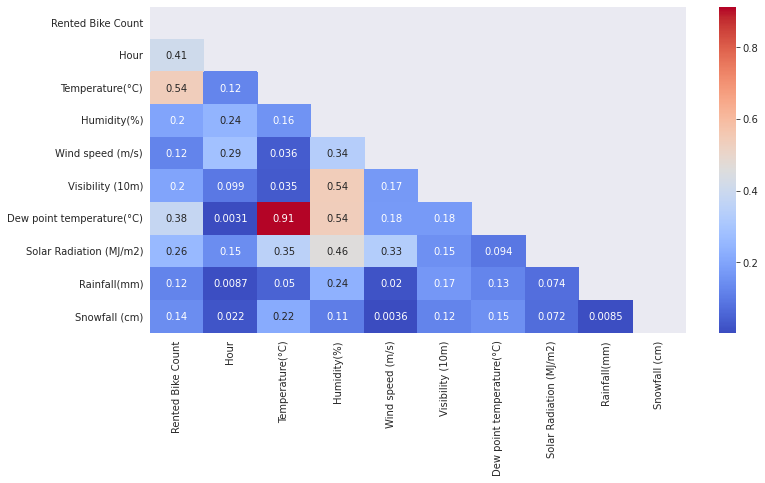

In [8]:
# Not much of a linear relationship here

plt.figure(figsize = (12,6))
# Getting the Upper Triangle of the co-relation matrix
correlation = data.corr()

matrix = np.triu(correlation)
sns.heatmap(abs(correlation), annot = True, cmap = 'coolwarm', mask=matrix)

plt.show()

In [9]:
# Small dataset

data.shape

(8760, 14)

In [ ]:
# No null values
# Hence no missing value cleaning is required

print ('Total null : {}\n'.format(data.isnull().sum().sum()))
data.isnull().sum()

In [ ]:
# data['Date'].dtype should not be object

data.dtypes

In [ ]:
# See number of unique values
# Number of days - Shows one year data
# Seasons - 4 (typical)
# Rest of data is bool type
# Date is a useless value

for x in data.describe(include = 'object').columns:
  print ("{} :  {} ". format(x, data[x].nunique()))

Date :  365 
Seasons :  4 
Holiday :  2 
Functioning Day :  2 


In [12]:
# Checking whether there are any duplicates
# 0 duplicates

len(data[data.duplicated()])

0

In [13]:
data.head(3)

,Date,Rented Bike Count,Hour,Temperature(°C),Humidity(%),Wind speed (m/s),Visibility (10m),Dew point temperature(°C),Solar Radiation (MJ/m2),Rainfall(mm),Snowfall (cm),Seasons,Holiday,Functioning Day
0,01/12/2017,254,0,-5.2,37,2.2,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
1,01/12/2017,204,1,-5.5,38,0.8,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
2,01/12/2017,173,2,-6.0,39,1.0,2000,-17.7,0.0,0.0,0.0,Winter,No Holiday,Yes


## **Data Cleaning + Feature Engineering**

In [14]:
# make a copy of the data

df = data.copy()
df.head(3)

,Date,Rented Bike Count,Hour,Temperature(°C),Humidity(%),Wind speed (m/s),Visibility (10m),Dew point temperature(°C),Solar Radiation (MJ/m2),Rainfall(mm),Snowfall (cm),Seasons,Holiday,Functioning Day
0,01/12/2017,254,0,-5.2,37,2.2,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
1,01/12/2017,204,1,-5.5,38,0.8,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
2,01/12/2017,173,2,-6.0,39,1.0,2000,-17.7,0.0,0.0,0.0,Winter,No Holiday,Yes


In [15]:
#change the name of the columns
# str.title() creates problems
# df.columns = df.columns.str.title()
# To change the string titles make a user defined function


df.columns = df.columns.str.replace(' ', '_')
df.columns = df.columns.str.lower()


def edit_string(txt):

  x = txt.find("(") -1
  if txt[x] == "_":
    hext = txt[0:x] + txt[x+1:]
    return hext
  
  else:
    return txt

def edit_string_temperature(txt):

  if 'temperature' in txt and '(' in txt and ')' in  txt :
    x = txt.find("(")
    txt = txt[:x]

    return txt


lstm = []
for x in df.columns:
  lstm.append(edit_string(x))

df.columns = lstm

lstm = []

del(lstm)

index = []
for x in df.columns:
  if 'temperature' in x:
    index.append(df.columns.get_loc(x))

index

for x in index:
  df.rename(columns = {df.columns[x] : edit_string_temperature(df.columns[x])} ,inplace = True)

df.head(3)



,date,rented_bike_count,hour,temperature,humidity(%),wind_speed(m/s),visibility(10m),dew_point_temperature,solar_radiation(mj/m2),rainfall(mm),snowfall(cm),seasons,holiday,functioning_day
0,01/12/2017,254,0,-5.2,37,2.2,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
1,01/12/2017,204,1,-5.5,38,0.8,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
2,01/12/2017,173,2,-6.0,39,1.0,2000,-17.7,0.0,0.0,0.0,Winter,No Holiday,Yes


In [16]:
# Transform feature - date
# date is object dtype and not date dtype

df.dtypes

date                       object
rented_bike_count           int64
hour                        int64
temperature               float64
humidity(%)                 int64
wind_speed(m/s)           float64
visibility(10m)             int64
dew_point_temperature     float64
solar_radiation(mj/m2)    float64
rainfall(mm)              float64
snowfall(cm)              float64
seasons                    object
holiday                    object
functioning_day            object
dtype: object

In [17]:
# date - Yearly data
# seasons - typical
# holiday, functioing_day - bool

for x in df.describe(include = 'object').columns:
  print ("{} : {}" .format(x ,df[x].nunique()))

date : 365
seasons : 4
holiday : 2
functioning_day : 2


In [18]:
# No need for a year column
# Its all in one month 

df['date'] = pd.to_datetime(df['date'], format="%d/%m/%Y")

df.insert(loc= 2, column = 'day_num', value = df['date'].dt.day)
df.insert(loc= 3, column = 'month', value = df['date'].dt.month)

df.head()

,date,rented_bike_count,day_num,month,hour,temperature,humidity(%),wind_speed(m/s),visibility(10m),dew_point_temperature,solar_radiation(mj/m2),rainfall(mm),snowfall(cm),seasons,holiday,functioning_day
0,2017-12-01,254,1,12,0,-5.2,37,2.2,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
1,2017-12-01,204,1,12,1,-5.5,38,0.8,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
2,2017-12-01,173,1,12,2,-6.0,39,1.0,2000,-17.7,0.0,0.0,0.0,Winter,No Holiday,Yes
3,2017-12-01,107,1,12,3,-6.2,40,0.9,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
4,2017-12-01,78,1,12,4,-6.0,36,2.3,2000,-18.6,0.0,0.0,0.0,Winter,No Holiday,Yes


In [19]:
# To check if errors have crept in when changing date
# Seems to be none

df.isnull().sum()

date                      0
rented_bike_count         0
day_num                   0
month                     0
hour                      0
temperature               0
humidity(%)               0
wind_speed(m/s)           0
visibility(10m)           0
dew_point_temperature     0
solar_radiation(mj/m2)    0
rainfall(mm)              0
snowfall(cm)              0
seasons                   0
holiday                   0
functioning_day           0
dtype: int64

In [20]:
target_variable = 'rented_bike_count'
categorical_features  = df.describe(include = 'object').columns.tolist()
numerical_features = df.describe().columns.tolist()
numerical_features.remove(target_variable)

In [21]:
categorical_features

['seasons', 'holiday', 'functioning_day']

In [22]:
numerical_features

['day_num',
 'month',
 'hour',
 'temperature',
 'humidity(%)',
 'wind_speed(m/s)',
 'visibility(10m)',
 'dew_point_temperature',
 'solar_radiation(mj/m2)',
 'rainfall(mm)',
 'snowfall(cm)']

In [23]:
# Getting data by date
# Aggregating data over unique date
# Dataset is hourly otherwise

df_dates =  \
    df[['date', 'temperature','humidity(%)', 'wind_speed(m/s)' ,
      'dew_point_temperature',  'solar_radiation(mj/m2)', 'rainfall(mm)' ,
      'snowfall(cm)', 'rented_bike_count']]\
    .groupby('date')\
    .agg({'temperature' : 'median', 'humidity(%)' : 'median', 
          'wind_speed(m/s)' : 'median', 'dew_point_temperature' : 'median', 
          'solar_radiation(mj/m2)' : 'sum', 'rainfall(mm)' : 'sum', 
          'snowfall(cm)' : 'sum', 'rented_bike_count' : 'sum'})
    
df_dates

list_seasons = []
list_holiday = []
list_functioning_day = []

for x in df['date'].unique():

  list_seasons.append(df[df['date'] == x ]['seasons'].mode()[0])
  list_holiday.append(df[df['date'] == x ]['holiday'].mode()[0])
  list_functioning_day.append(df[df['date'] == x ]['functioning_day'].mode()[0])



df_dates.insert(loc = len(df_dates.columns), column = 'seasons', value = list_seasons)
df_dates.insert(loc = len(df_dates.columns), column = 'holiday', value = list_holiday)
df_dates.insert(loc = len(df_dates.columns), column = 'functioning_day', value = list_functioning_day)

df_dates.head()

,temperature,humidity(%),wind_speed(m/s),dew_point_temperature,solar_radiation(mj/m2),rainfall(mm),snowfall(cm),rented_bike_count,seasons,holiday,functioning_day
date,,,,,,,,,,,
2017-12-01,-1.10,37.5,1.4,-17.40,5.97,0.0,0.0,9539,Winter,No Holiday,Yes
2017-12-02,2.70,55.5,1.6,-5.55,6.33,0.0,0.0,8523,Winter,No Holiday,Yes
2017-12-03,4.35,84.5,1.6,2.65,3.01,4.0,0.0,7222,Winter,No Holiday,Yes
2017-12-04,-0.25,43.5,3.6,-12.95,6.79,0.1,0.0,8729,Winter,No Holiday,Yes
2017-12-05,-3.80,34.5,0.0,-17.70,0.86,0.0,0.0,8307,Winter,No Holiday,Yes


## **Sanity Check**

In [25]:
# No snowfall in summer 
# Seems logical

df_dates[df_dates['seasons'] == 'Summer']['snowfall(cm)'].max()


0.0

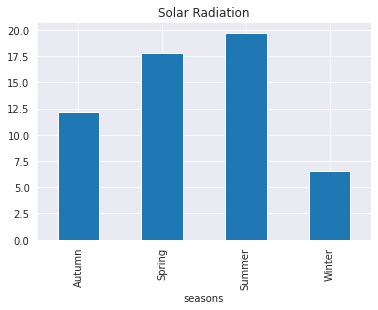

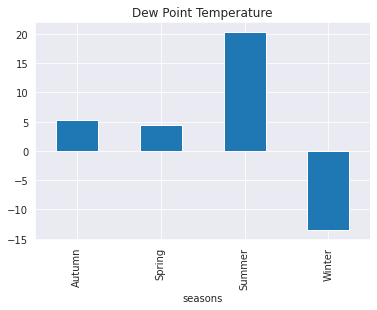

In [26]:
# The seasonal vairation of solar radiation seems logical

plt.figure()
plt.title('Solar Radiation')
df_dates.groupby('seasons')['solar_radiation(mj/m2)'].median().plot.bar()
plt.show()

# print("\n", df_dates[['seasons', 'solar_radiation(mj/m2)']].groupby('seasons').median(), "\n")

# The seasonal vairation of dew point temperature seems logical

plt.figure()
plt.title('Dew Point Temperature')
df_dates.groupby('seasons')['dew_point_temperature'].median().plot.bar()
plt.show()

# df_dates[['seasons', 'dew_point_temperature']].groupby('seasons').median()

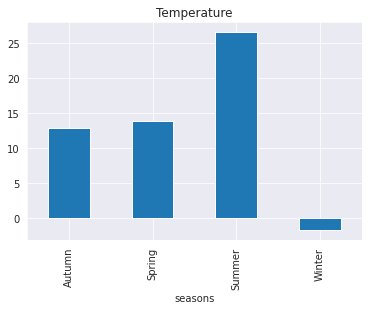

In [27]:
# Seasonal temperature variation seems logical

plt.figure()
plt.title('Temperature')
df_dates.groupby('seasons')['temperature'].median().plot.bar()
plt.show()

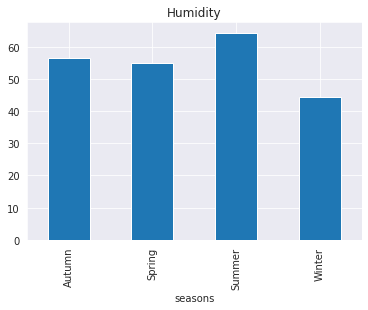

In [28]:
# Humidity variation seems somewhat logical
# No real pattern

plt.figure()
plt.title('Humidity')
df_dates.groupby('seasons')['humidity(%)'].median().plot.bar()
plt.show()

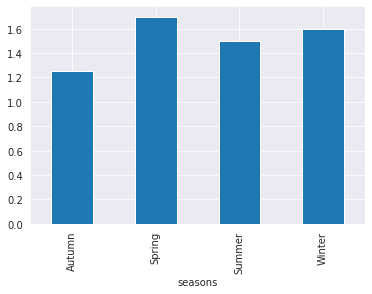

In [29]:
# Nothing to infer from this 
# No idea how wind speeds corresponds to seasons

df_dates.groupby('seasons')['wind_speed(m/s)'].median().plot.bar()

seasons  holiday   
Autumn   No Holiday    86
         Holiday        5
Spring   No Holiday    89
         Holiday        3
Summer   No Holiday    90
         Holiday        2
Winter   No Holiday    82
         Holiday        8
Name: holiday, dtype: int64


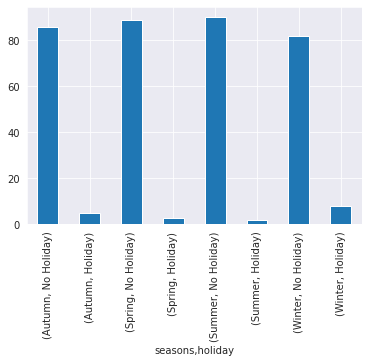

In [31]:
# Quite the way more insightful than i thought it would
# Korea doesnt seems to have very many holidays
# Winter may have more holidays because of excess snow ??

df_dates.groupby('seasons')['holiday'].value_counts().plot.bar()

print(df_dates.groupby('seasons')['holiday'].value_counts())





*   Conclusion - Sanity check passed
*   The data follows the logic of weather 
*   High confidence
*   It is a well cleaned dataset





## **Exploration & Visualisation**

### **Categorical Features**

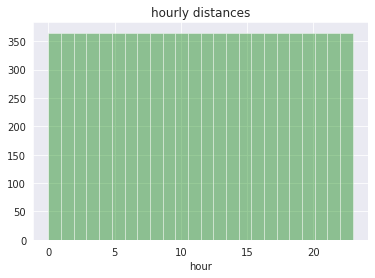

{365}

In [39]:
# Most natural phenomena should be normally distributed
# Normal - Humidity(%), Temperature( C)
# Normal w/skew - Wind speed (m/s),  Dew point temperature(C)

# Skewed - Visibility (10m), Solar Radiation (MJ/m2) , Rainfall(mm) , Snowfall (cm)                
# Every hour has equal counts 

plt.figure()
sns.distplot(a = df['hour'], kde = False, bins = 24, color = 'green')
plt.title('hourly distances')
plt.show()

set(df['hour'].value_counts().values)

In [ ]:
df.head()

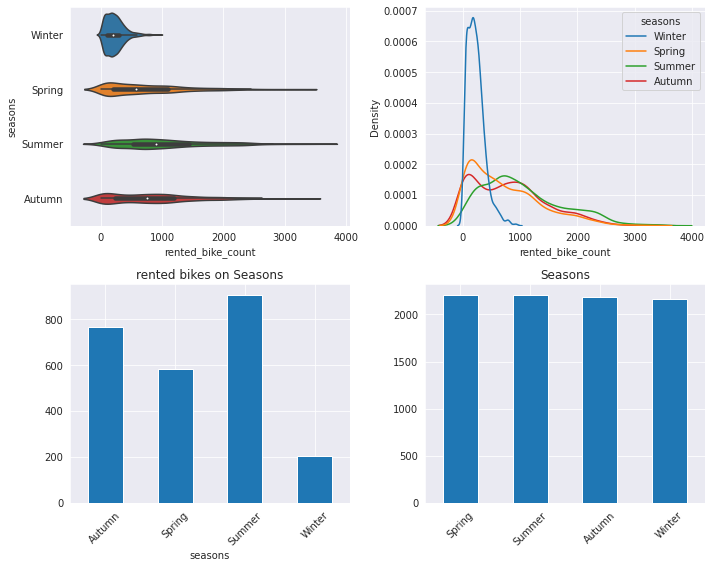

seasons
Autumn    763.5
Spring    583.0
Summer    905.5
Winter    203.0
Name: rented_bike_count, dtype: float64


seasons
Autumn     819.597985
Spring     730.031250
Summer    1034.073370
Winter     225.541204
Name: rented_bike_count, dtype: float64

In [41]:
# To see the bikes rented by holiday category
# Clear difference 

plt.figure(figsize = (10,8))

plt.subplot(2,2,1)
sns.violinplot(x = df['rented_bike_count'], y = df['seasons'])


plt.subplot(2,2,2)
sns.kdeplot(data=df, x="rented_bike_count", hue="seasons")

#sns.kdeplot(data = df, x = df.loc[df['seasons'] == 'Winter', 'rented_bike_count'], color = 'blue')
#sns.kdeplot(data = df, x = df.loc[df['seasons'] == 'Summer', 'rented_bike_count'], color = 'red')
#sns.kdeplot(data = df, x = df.loc[df['seasons'] == 'Autumn', 'rented_bike_count'], color = 'pink')
#sns.kdeplot(data = df, x = df.loc[df['seasons'] == 'Spring', 'rented_bike_count'], color = 'green')

plt.subplot(2,2,3)
df.groupby('seasons')['rented_bike_count'].median().plot(
    kind = 'bar', title = 'rented bikes on Seasons', rot = 45)


plt.subplot(2,2,4)
df['seasons'].value_counts().plot(kind = 'bar', title = 'Seasons', rot = 45)

# df.groupby('holiday')['rented_bike_count'].median().plot(
#    kind = 'bar', title = 'rented bikes on functioning days categories', rot = 45)




plt.tight_layout()
plt.show()

print(df.groupby('seasons')['rented_bike_count'].median())
df.groupby('seasons')['rented_bike_count'].mean()

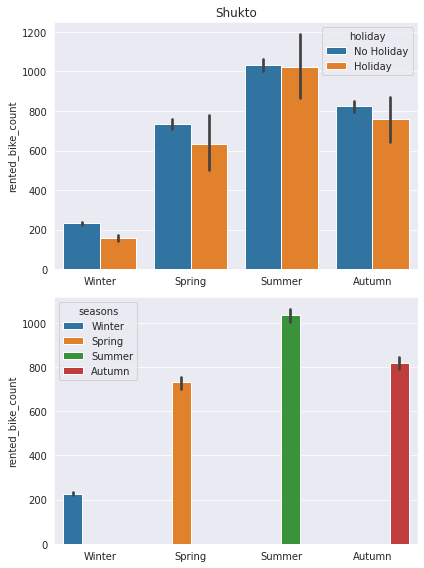

In [83]:
# To see the bikes rented by holiday category
# Clear difference 

fig, axs = plt.subplots(2)

fig.set_figwidth(6)
fig.set_figheight(8)

sns.barplot(x="seasons", y="rented_bike_count", hue="holiday", data=df, ax = axs[0])
axs[0].set_title('Shukto')
axs[0].set_xlabel('')

sns.barplot(x="seasons", y="rented_bike_count", hue="seasons", data=df, ax = axs[1])
axs[1].set_title('')
axs[1].set_xlabel('')

fig.tight_layout()

In [44]:
df.head(3)

,date,rented_bike_count,day_num,month,hour,temperature,humidity(%),wind_speed(m/s),visibility(10m),dew_point_temperature,solar_radiation(mj/m2),rainfall(mm),snowfall(cm),seasons,holiday,functioning_day
0,2017-12-01,254,1,12,0,-5.2,37,2.2,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
1,2017-12-01,204,1,12,1,-5.5,38,0.8,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
2,2017-12-01,173,1,12,2,-6.0,39,1.0,2000,-17.7,0.0,0.0,0.0,Winter,No Holiday,Yes


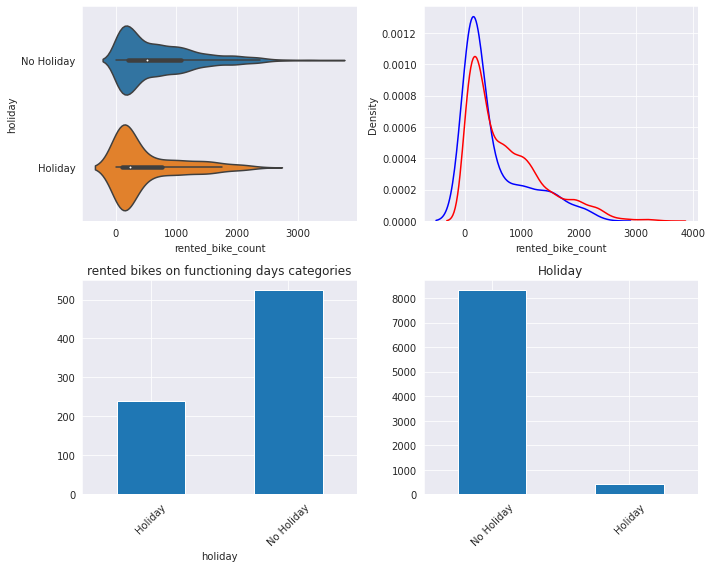

holiday
Holiday       240.0
No Holiday    524.5
Name: rented_bike_count, dtype: float64


holiday
Holiday       499.756944
No Holiday    715.228026
Name: rented_bike_count, dtype: float64

In [ ]:
# To see the bikes rented by holiday category
# Clear diffeerence 

plt.figure(figsize = (10,8))

plt.subplot(2,2,1)
sns.violinplot(x = df['rented_bike_count'], y = df['holiday'])


plt.subplot(2,2,2)

# Use two kde plots because they are unequally distributed
sns.kdeplot(data = df, x = df.loc[df['holiday'] == 'Holiday', 'rented_bike_count'], color = 'blue')
sns.kdeplot(data = df, x = df.loc[df['holiday'] == 'No Holiday', 'rented_bike_count'], color = 'red')


plt.subplot(2,2,3)
df.groupby('holiday')['rented_bike_count'].median().plot(
    kind = 'bar', title = 'rented bikes on functioning days categories', rot = 45)


plt.subplot(2,2,4)
df['holiday'].value_counts().plot(kind = 'bar', title = 'Holiday', rot = 45)

# df.groupby('holiday')['rented_bike_count'].median().plot(
#    kind = 'bar', title = 'rented bikes on functioning days categories', rot = 45)


plt.tight_layout()
plt.show()

print(df.groupby('holiday')['rented_bike_count'].median())
df.groupby('holiday')['rented_bike_count'].mean()

(432,)

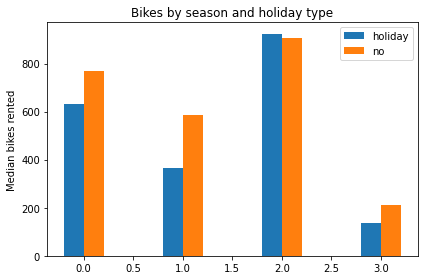

In [ ]:

# df[holiday] has two possibilites - Holiday or Not Holiday
# It seems bikes are rented more on Working Day (No Holiday)
# df[holiday] is a pertinent feature with predictive power

df.loc[df['holiday'] == 'Holiday'].groupby('seasons')['rented_bike_count'].median().tolist()

df.loc[df['holiday'] == 'No Holiday'].groupby('seasons')['rented_bike_count'].median().tolist()

labels = df.loc[df['holiday'] == 'Holiday'].groupby('seasons')['rented_bike_count'].median().index.tolist()

holiday = df.loc[df['holiday'] == 'Holiday'].groupby('seasons')['rented_bike_count'].median().tolist()
no_holiday = df.loc[df['holiday'] == 'No Holiday'].groupby('seasons')['rented_bike_count'].median().tolist()


x = np.arange(len(labels))  # the label locations
width = 0.2  # the width of the bars


fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, holiday, width, label='holiday')
rects2 = ax.bar(x + width/2, no_holiday, width, label='no')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Median bikes rented')
ax.set_title('Bikes by season and holiday type')
ax.set_xticks(x, labels)

# labels ['Autumn', 'Spring', 'Summer', 'Winter']
ax.legend()

# ax.bar_label(rects1)
# ax.bar_label(rects2)

fig.tight_layout()


plt.show()

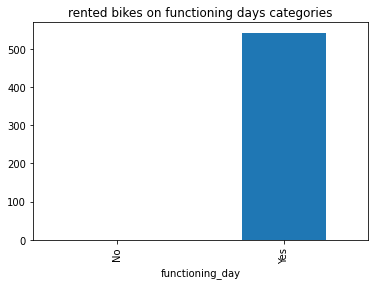

functioning_day
No       0.0
Yes    542.0
Name: rented_bike_count, dtype: float64

In [ ]:
# Functioning day means the company is functioning
# So no rentals on that day of course 
# functioning has predictive power

# df.groupby('functioning_day')['rented_bike_count'].max()
plt.figure()
df.groupby('functioning_day')['rented_bike_count'].median().plot(
    kind = 'bar', title = 'rented bikes on functioning days categories')
plt.show()

df.groupby('functioning_day')['rented_bike_count'].median()

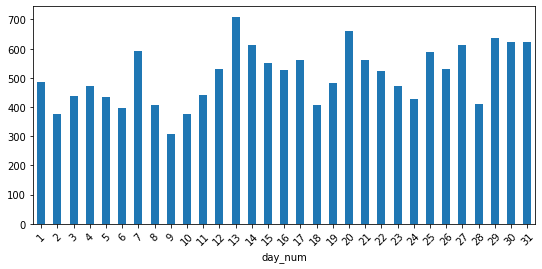

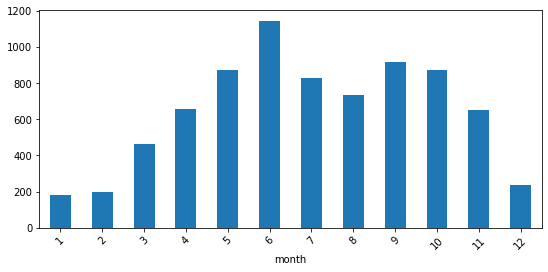

In [ ]:
# Check df[day_num] and df[month]
# Analysis of month and day_num
# day_num doesnt have a patttern
# df[month] corresponds to what we saw in seasons

plt.figure(figsize = (9, 4))
df[['rented_bike_count','day_num']].groupby('day_num')['rented_bike_count'].median().plot.bar(rot  = 45)
plt.show()

plt.figure(figsize = (9, 4))
df[['rented_bike_count','month']].groupby('month')['rented_bike_count'].median().plot.bar(rot  = 45)
plt.show()

In [45]:
# Your weather dashboard

df1 = df[['seasons', 'rainfall(mm)']].groupby('seasons').agg({'rainfall(mm)' : ['min', 'max', 'median', 'mean']})\
.rename(columns = {'min' : 'min_rain',
                   'max' : 'max_rain',
                   'median' : 'median_rain',
                   'mean' : 'mean_rain'})

df2 = df[['seasons', 'snowfall(cm)']].groupby('seasons').agg({'snowfall(cm)' : ['min', 'max', 'median', 'mean']})\
.rename(columns = {'min' : 'min_snow',
                   'max' : 'max_snow',
                   'median' : 'median_snow',
                   'mean' : 'mean_snow'})

df3 = df[['seasons', 'temperature']].groupby('seasons').agg({'temperature' : ['min', 'max', 'median', 'mean']})\
.rename(columns = {'min' : 'min_temp',
                   'max' : 'max_temp',
                   'median' : 'median_temp',
                   'mean' : 'mean_temp'})

df_weather = pd.concat([df1, df2, df3],axis=1)

In [ ]:
del(df1)
del(df2)
del(df3)

In [46]:
# Just to get a weather dashboard

df_weather

rainfall(mm)                                snowfall(cm)           \
            min_rain max_rain median_rain mean_rain     min_snow max_snow   
seasons                                                                     
Autumn           0.0     18.0         0.0  0.122756          0.0      8.8   
Spring           0.0     35.0         0.0  0.182880          0.0      0.0   
Summer           0.0     29.5         0.0  0.253487          0.0      0.0   
Winter           0.0      9.5         0.0  0.032824          0.0      5.1   

                              temperature                                  
        median_snow mean_snow    min_temp max_temp median_temp  mean_temp  
seasons                                                                    
Autumn          0.0  0.056319        -3.0     30.5       13.85  14.120833  
Spring          0.0  0.000000        -6.6     29.4       13.30  13.046694  
Summer          0.0  0.000000        16.3     39.4       26.60  26.582790  
Winter          0.0  0.247500       -17.8     10.3       -2.20  -2.540463

### **Numerical features**

In [ ]:
df.head(3)

,date,day_num,month,rented_bike_count,hour,temperature,humidity(%),wind_speed(m/s),visibility(10m),dew_point_temperature,solar_radiation(mj/m2),rainfall(mm),snowfall(cm),seasons,holiday,functioning_day
0,2017-12-01,1,12,254,0,-5.2,37,2.2,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
1,2017-12-01,1,12,204,1,-5.5,38,0.8,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
2,2017-12-01,1,12,173,2,-6.0,39,1.0,2000,-17.7,0.0,0.0,0.0,Winter,No Holiday,Yes


In [ ]:
numerical_features

['day_num',
 'month',
 'hour',
 'temperature',
 'humidity(%)',
 'wind_speed(m/s)',
 'visibility(10m)',
 'dew_point_temperature',
 'solar_radiation(mj/m2)',
 'rainfall(mm)',
 'snowfall(cm)']

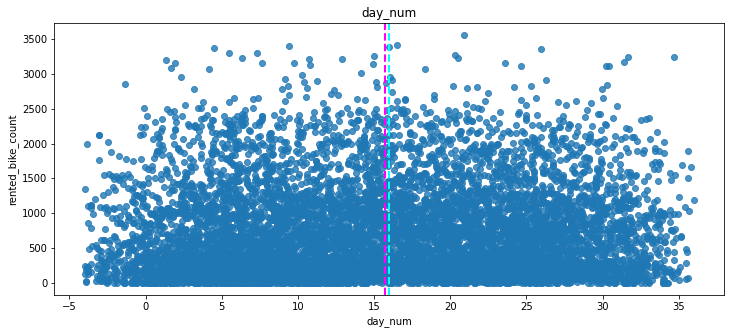

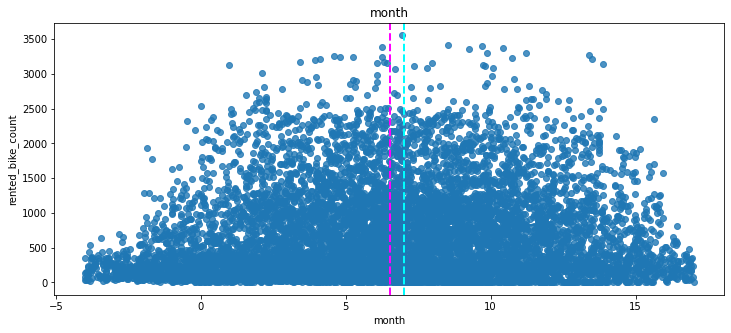

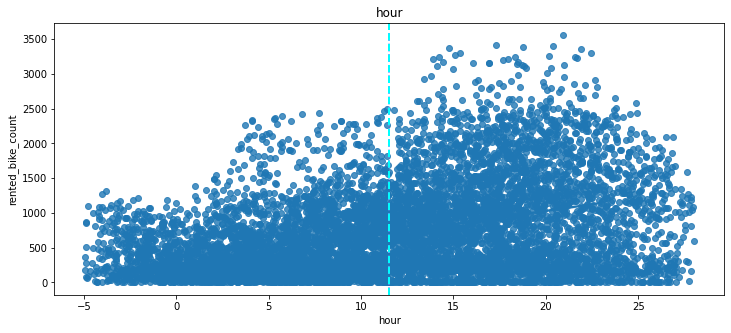

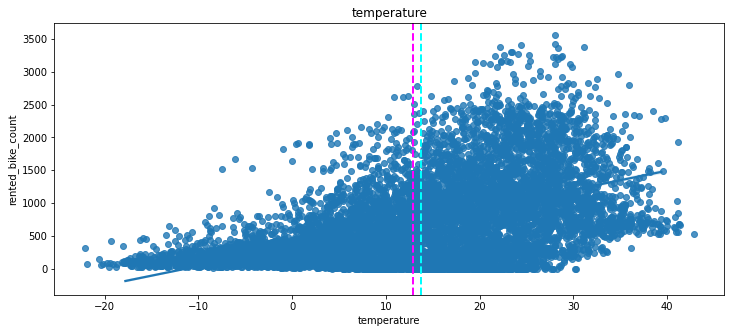

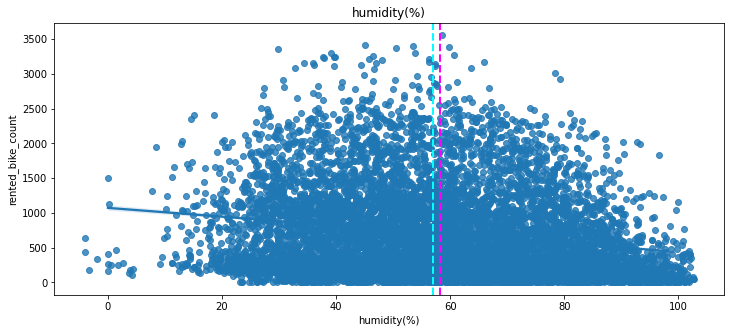

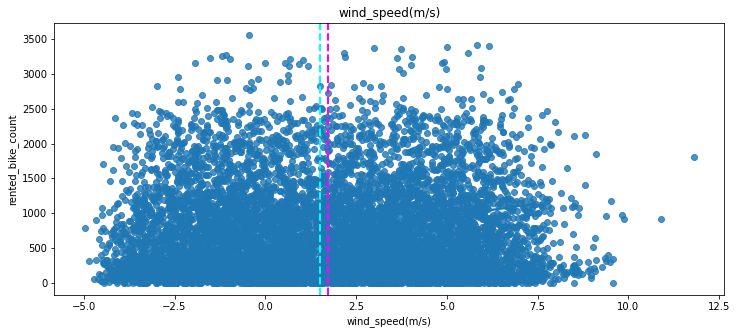

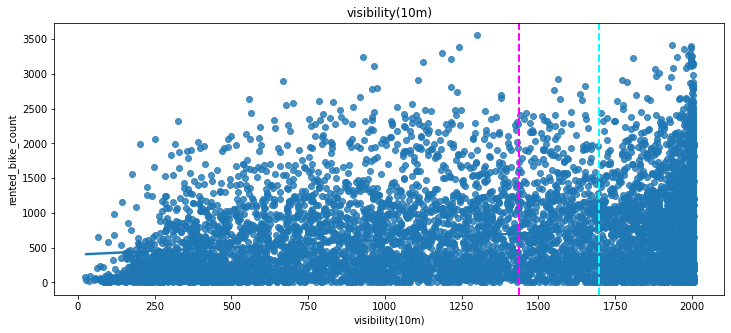

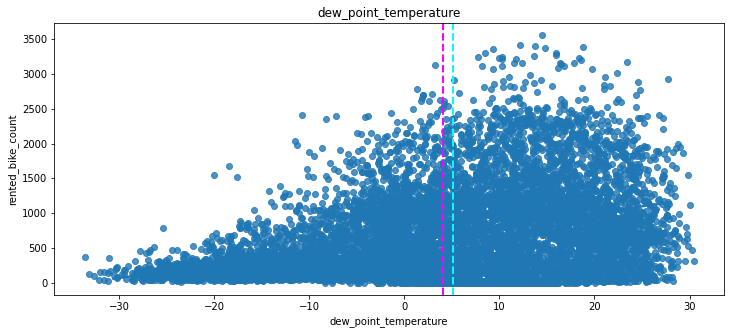

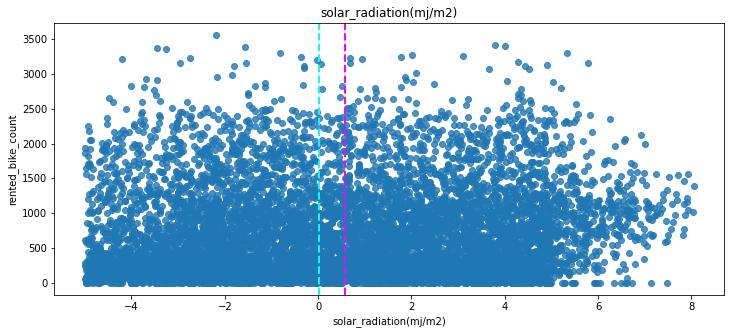

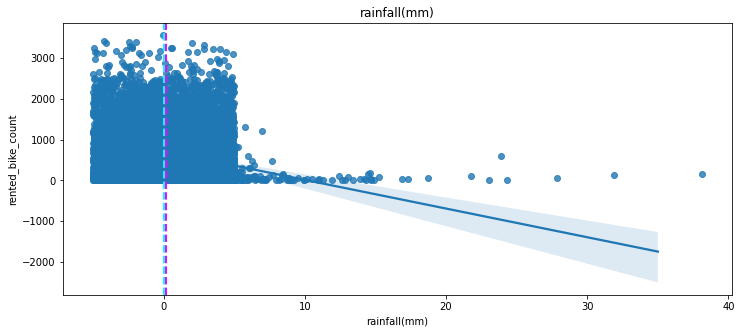

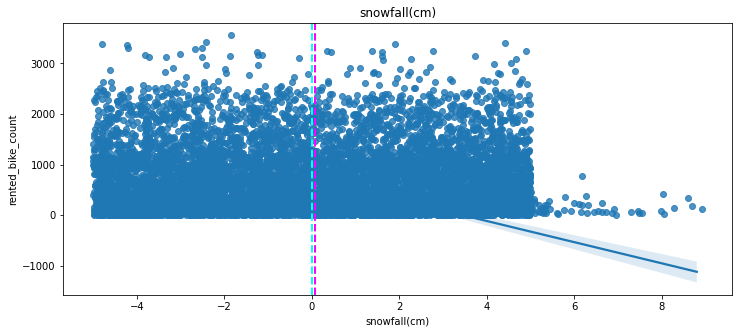

In [ ]:
# hour : +ve correlated  (This will be periodic)
# temperature : + ve correlated 
# humidity : moderately -ve correlated 
# windspeed : moderately +ve correlated

# visibility(10m): moderately +ve correlated
# dew_point_temperature - +ve correlated
# rainfall(mm) : -ve correlated
# snowfall(cm) : -ve correlated


for col in numerical_features:
    fig = plt.figure(figsize=(12,5))
    ax = fig.gca()
    feature = df[col]
    sns.regplot(x=feature, y=df['rented_bike_count'], scatter = True, fit_reg = True, x_jitter= 5, y_jitter = 0.1 )
    # feature.hist(bins=50, ax = ax)
    ax.axvline(feature.mean(), color='magenta', linestyle='dashed', linewidth=2)
    ax.axvline(feature.median(), color='cyan', linestyle='dashed', linewidth=2)    
    ax.set_title(col)
plt.show()

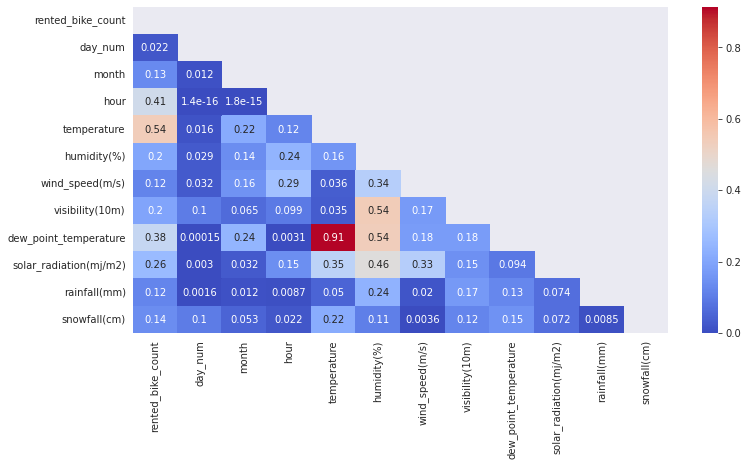

In [ ]:
# Really seems like no point doing this 
# Not much of a linear relationship anyway

plt.figure(figsize=(12,6))

correlation = df.corr()
matrix = np.triu(correlation) 

sns.heatmap(abs(correlation), annot=True, cmap='coolwarm', mask=matrix )

#sns.heatmap(abs(correlation), annot=True, cmap='coolwarm')

In [ ]:
numerical_features

In [ ]:
df.head(3)

,date,day_num,month,rented_bike_count,hour,temperature,humidity(%),wind_speed(m/s),visibility(10m),dew_point_temperature,solar_radiation(mj/m2),rainfall(mm),snowfall(cm),seasons,holiday,functioning_day
0,2017-12-01,1,12,254,0,-5.2,37,2.2,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
1,2017-12-01,1,12,204,1,-5.5,38,0.8,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
2,2017-12-01,1,12,173,2,-6.0,39,1.0,2000,-17.7,0.0,0.0,0.0,Winter,No Holiday,Yes


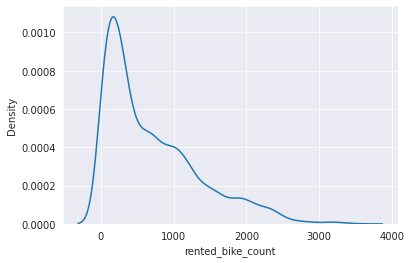

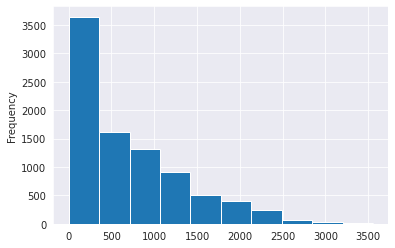

In [ ]:
# How can this feature impact 
# Its important that dev and test set are the same
# In real world the test set 

plt.figure()
# df['rented_bike_count'].plot(kind = 'kde')
sns.kdeplot(data = df, x = 'rented_bike_count', gridsize = 500)
plt.show()

plt.figure()
df['rented_bike_count'].plot(kind = 'hist')
plt.show()

In [ ]:
df.loc[df['rented_bike_count'] == 0].shape

(295, 16)

In [ ]:
# Number of days there is no bike rentals
# this is when it is a holiday

df_dates[df_dates['rented_bike_count'] == 0].shape

(12, 11)

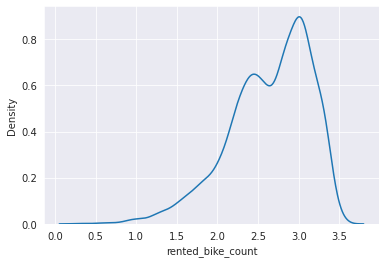

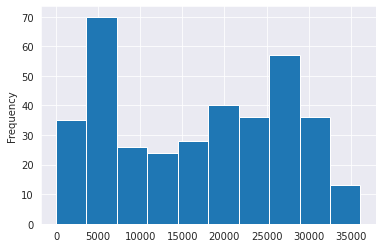

In [ ]:
# How can this feature impact 
# Its important that dev and test set are the same
# In real world the test set 

bike_count = np.log10(df['rented_bike_count'])
plt.figure()
# df['rented_bike_count'].plot(kind = 'kde')
sns.kdeplot(data = df_dates, x = bike_count, gridsize = 500)
plt.show()

plt.figure()
df_dates['rented_bike_count'].plot(kind = 'hist')
plt.show()

del(bike_count)

In [ ]:
df.head(4)

,date,rented_bike_count,day_num,month,hour,temperature,humidity(%),wind_speed(m/s),visibility(10m),dew_point_temperature,solar_radiation(mj/m2),rainfall(mm),snowfall(cm),seasons,holiday,functioning_day
0,2017-12-01,254,1,12,0,-5.2,37,2.2,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
1,2017-12-01,204,1,12,1,-5.5,38,0.8,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
2,2017-12-01,173,1,12,2,-6.0,39,1.0,2000,-17.7,0.0,0.0,0.0,Winter,No Holiday,Yes
3,2017-12-01,107,1,12,3,-6.2,40,0.9,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes


In [ ]:
numerical_features

['day_num',
 'month',
 'hour',
 'temperature',
 'humidity(%)',
 'wind_speed(m/s)',
 'visibility(10m)',
 'dew_point_temperature',
 'solar_radiation(mj/m2)',
 'rainfall(mm)',
 'snowfall(cm)']

In [ ]:
# Well use df_dates for better understanding of the data

df_dates.head()

,temperature,humidity(%),wind_speed(m/s),dew_point_temperature,solar_radiation(mj/m2),rainfall(mm),snowfall(cm),rented_bike_count,seasons,holiday,functioning_day
date,,,,,,,,,,,
2017-12-01,-1.10,37.5,1.4,-17.40,5.97,0.0,0.0,9539,Winter,No Holiday,Yes
2017-12-02,2.70,55.5,1.6,-5.55,6.33,0.0,0.0,8523,Winter,No Holiday,Yes
2017-12-03,4.35,84.5,1.6,2.65,3.01,4.0,0.0,7222,Winter,No Holiday,Yes
2017-12-04,-0.25,43.5,3.6,-12.95,6.79,0.1,0.0,8729,Winter,No Holiday,Yes
2017-12-05,-3.80,34.5,0.0,-17.70,0.86,0.0,0.0,8307,Winter,No Holiday,Yes


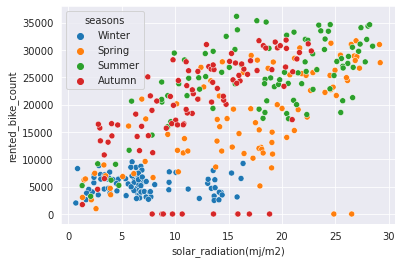

In [ ]:
plt.figure()
sns.scatterplot(data=df_dates, x="solar_radiation(mj/m2)",\
                y="rented_bike_count", hue="seasons"\
                )

plt.show()

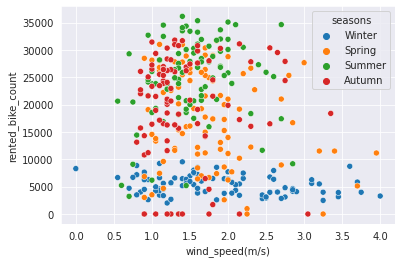

In [ ]:
plt.figure()
sns.scatterplot(data=df_dates, x="wind_speed(m/s)",\
                y="rented_bike_count", hue="seasons"\
                )

plt.show()

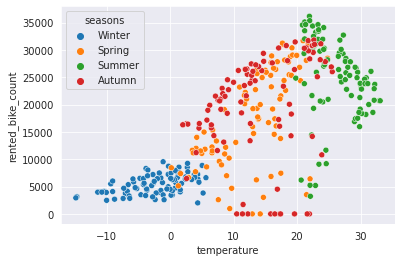

In [ ]:

plt.figure()
sns.scatterplot(data=df_dates, x="temperature",\
                y="rented_bike_count", hue="seasons"\
               )

plt.show()

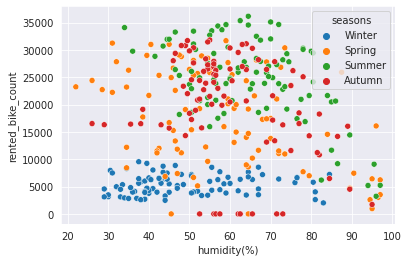

In [ ]:
plt.figure()
sns.scatterplot(data=df_dates, x="humidity(%)",\
                y="rented_bike_count", hue="seasons"
                )

plt.show()

In [ ]:
df_dates.head(3)

,temperature,humidity(%),wind_speed(m/s),dew_point_temperature,solar_radiation(mj/m2),rainfall(mm),snowfall(cm),rented_bike_count,seasons,holiday,functioning_day
date,,,,,,,,,,,
2017-12-01,-1.10,37.5,1.4,-17.40,5.97,0.0,0.0,9539,Winter,No Holiday,Yes
2017-12-02,2.70,55.5,1.6,-5.55,6.33,0.0,0.0,8523,Winter,No Holiday,Yes
2017-12-03,4.35,84.5,1.6,2.65,3.01,4.0,0.0,7222,Winter,No Holiday,Yes


In [ ]:
# Not required

'''
fig,ax = plt.subplots(3,3,figsize=(15,10))
row = col = 0
for n,i in enumerate(numeric_features):
    if (n%3 == 0) & (n > 0):
        row += 1
        col = 0
    sns.regplot(x=i,y="target",data=data,ax=ax[row,col],ci=False)
    col += 1

num_tgt = numeric_features.copy() 
num_tgt.append('target')
fig = plt.figure(figsize=(8,8))
sns.heatmap(data[num_tgt].corr(method='pearson'),annot=True,fmt='.2f',mask=np.triu(data[num_tgt].corr(method='pearson')),cbar=False)

fig = plt.figure(figsize=(8,8))
sns.heatmap(data[num_tgt].corr(method='kendall'),annot=True,fmt='.2f',mask=np.triu(data[num_tgt].corr(method='pearson')),cbar=False)

fig = plt.figure(figsize=(8,8))
sns.heatmap(data[num_tgt].corr(method='kendall'),annot=True,fmt='.2f',mask=np.triu(data[num_tgt].corr(method='pearson')),cbar=False)

'''

'\nfig,ax = plt.subplots(3,3,figsize=(15,10))\nrow = col = 0\nfor n,i in enumerate(numeric_features):\n    if (n%3 == 0) & (n > 0):\n        row += 1\n        col = 0\n    sns.regplot(x=i,y="target",data=data,ax=ax[row,col],ci=False)\n    col += 1\n\nnum_tgt = numeric_features.copy() \nnum_tgt.append(\'target\')\nfig = plt.figure(figsize=(8,8))\nsns.heatmap(data[num_tgt].corr(method=\'pearson\'),annot=True,fmt=\'.2f\',mask=np.triu(data[num_tgt].corr(method=\'pearson\')),cbar=False)\n\nfig = plt.figure(figsize=(8,8))\nsns.heatmap(data[num_tgt].corr(method=\'kendall\'),annot=True,fmt=\'.2f\',mask=np.triu(data[num_tgt].corr(method=\'pearson\')),cbar=False)\n\nfig = plt.figure(figsize=(8,8))\nsns.heatmap(data[num_tgt].corr(method=\'kendall\'),annot=True,fmt=\'.2f\',mask=np.triu(data[num_tgt].corr(method=\'pearson\')),cbar=False)\n\n'

## **Outlier - Detection and Removal**

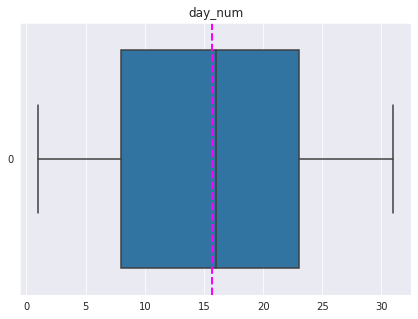

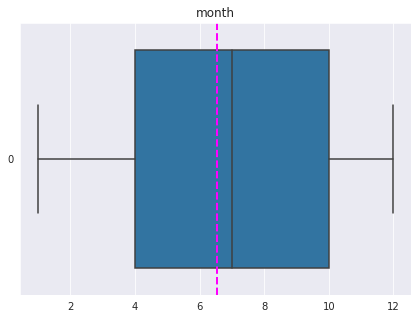

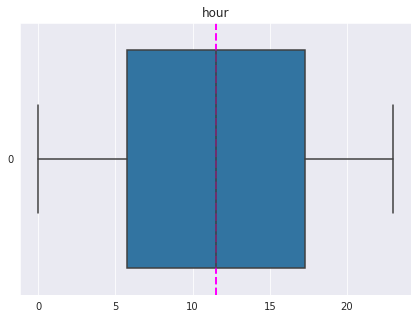

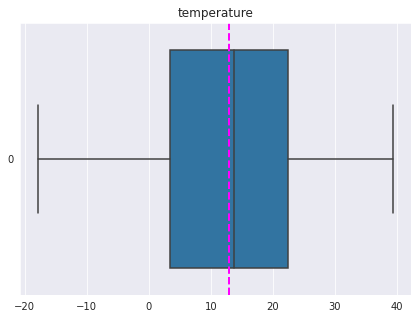

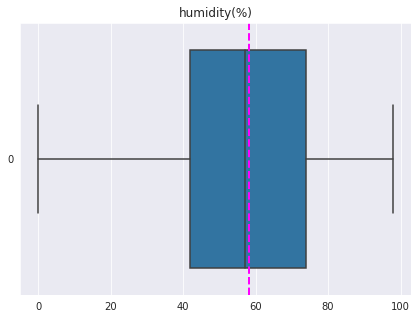

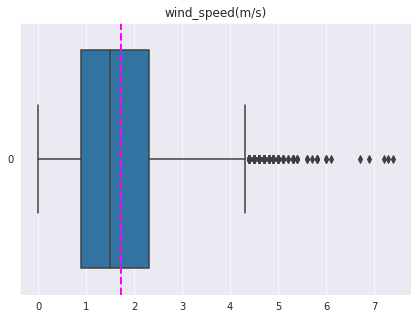

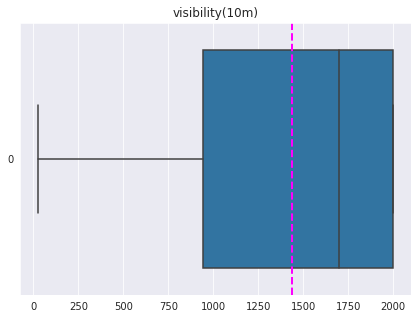

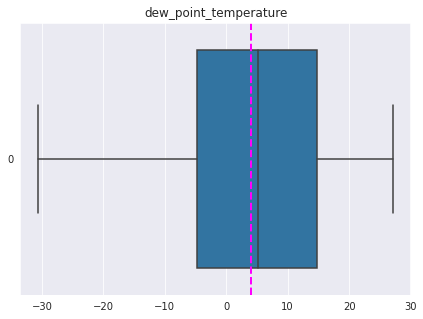

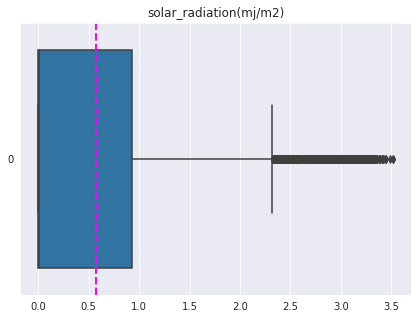

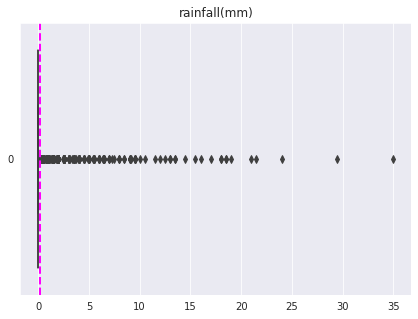

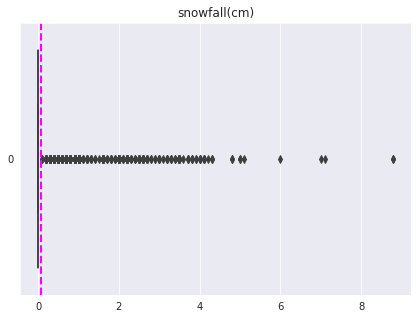

In [ ]:
# Checking for outliers
# Outliers - Windspeed, solar_radiation(mj/m2), rainfall(mm), snowfall(cm)

for col in numerical_features:
    fig = plt.figure(figsize=(7,5))
    ax = fig.gca()
    feature = df[col]
    sns.boxplot(data = feature, orient = 'h')
    # feature.hist(bins=50, ax = ax)
    ax.axvline(feature.mean(), color='magenta', linestyle='dashed', linewidth=2)
    # ax.axvline(feature.median(), color='cyan', linestyle='dashed', linewidth=2)    
    ax.set_title(col)
plt.show()

Several features have outliers \
Tree based model may handle this well
 

## **Feature Importance**

In [ ]:
categorical_features

['seasons', 'holiday', 'functioning_day']

Rank: 0, Score: 0.0
Rank: 1, Score: 0.0023831644528804668
Rank: 2, Score: 0.005061128969451542
Rank: 3, Score: 0.006074144286992156
Rank: 4, Score: 0.007049593459080383
Rank: 5, Score: 0.007905388888914011
Rank: 6, Score: 0.008782594217328037
Rank: 7, Score: 0.010940089233178041
Rank: 8, Score: 0.011950949472460783
Rank: 9, Score: 0.03262874953954848
Rank: 10, Score: 0.04542725078637005
Rank: 11, Score: 0.06522374629039444
Rank: 12, Score: 0.08596475443190013
Rank: 13, Score: 0.10536234600194838
Rank: 14, Score: 0.11589234822283068
Rank: 15, Score: 0.11928686432926561
Rank: 16, Score: 0.12070385793060473
Rank: 17, Score: 0.12278834119175822
Rank: 18, Score: 0.12657468829509375

 



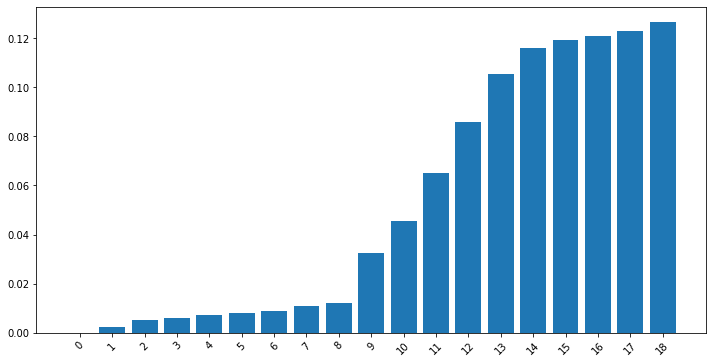

In [ ]:
from sklearn.tree import DecisionTreeClassifier

X  = df.iloc[:, 1:].copy()
X = pd.get_dummies(X, columns=categorical_features, prefix=["seasons", "holiday", "functioning_day"])

y = X.pop(target_variable)


model = DecisionTreeClassifier()
# fit the model
model.fit(X, y)


# get importance
importance = model.feature_importances_
importance=np.sort(importance)

# summarize feature importance
for i,v in enumerate(importance):
    print('Rank: {}, Score: {}'.format(i, v))

print ("\n \n")


# plot feature importance
plt.figure(figsize = (12,6))
plt.xticks(ticks = [x for x in range(len(importance))], rotation =45)
plt.bar([x for x in range(len(importance))], importance)
plt.show()

In [ ]:
X.head()

,day_num,month,hour,temperature,humidity(%),wind_speed(m/s),visibility(10m),dew_point_temperature,solar_radiation(mj/m2),rainfall(mm),snowfall(cm),seasons_Autumn,seasons_Spring,seasons_Summer,seasons_Winter,holiday_Holiday,holiday_No Holiday,functioning_day_No,functioning_day_Yes
0,1,12,0,-5.2,37,2.2,2000,-17.6,0.0,0.0,0.0,0,0,0,1,0,1,0,1
1,1,12,1,-5.5,38,0.8,2000,-17.6,0.0,0.0,0.0,0,0,0,1,0,1,0,1
2,1,12,2,-6.0,39,1.0,2000,-17.7,0.0,0.0,0.0,0,0,0,1,0,1,0,1
3,1,12,3,-6.2,40,0.9,2000,-17.6,0.0,0.0,0.0,0,0,0,1,0,1,0,1
4,1,12,4,-6.0,36,2.3,2000,-18.6,0.0,0.0,0.0,0,0,0,1,0,1,0,1


In [ ]:
model.feature_importances_

array([0.10536235, 0.04542725, 0.08596475, 0.12278834, 0.12070386,
       0.11928686, 0.11589235, 0.12657469, 0.06522375, 0.00878259,
       0.00704959, 0.01094009, 0.01195095, 0.00790539, 0.00238316,
       0.00506113, 0.00607414, 0.03262875, 0.        ])

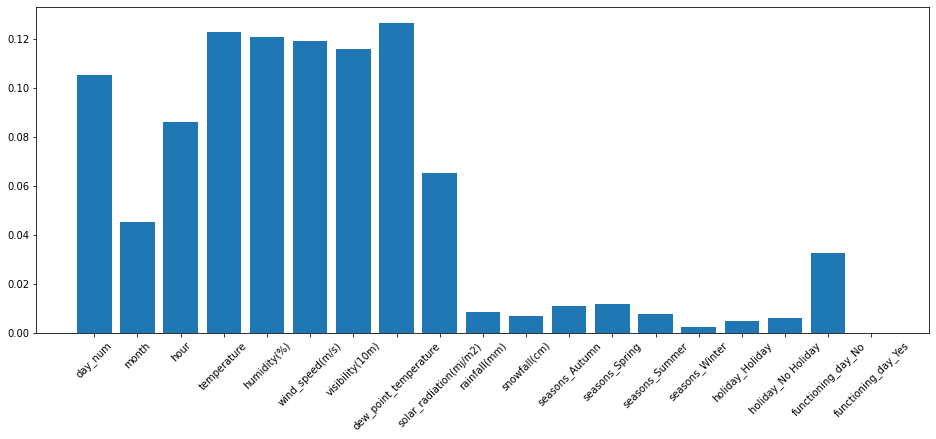

In [ ]:
# Stochastic nature of the algorithm
# Different feature importances


features = list(zip(X.columns, model.feature_importances_))

plt.figure(figsize = (16,6))
plt.bar([x[0] for x in features], [x[1] for x in features])
plt.xticks(rotation = 45)
plt.show()
# del(features)

In [ ]:
X.head()

,day_num,month,hour,temperature,humidity(%),wind_speed(m/s),visibility(10m),dew_point_temperature,solar_radiation(mj/m2),rainfall(mm),snowfall(cm),seasons_Autumn,seasons_Spring,seasons_Summer,seasons_Winter,holiday_Holiday,holiday_No Holiday,functioning_day_No,functioning_day_Yes
0,1,12,0,-5.2,37,2.2,2000,-17.6,0.0,0.0,0.0,0,0,0,1,0,1,0,1
1,1,12,1,-5.5,38,0.8,2000,-17.6,0.0,0.0,0.0,0,0,0,1,0,1,0,1
2,1,12,2,-6.0,39,1.0,2000,-17.7,0.0,0.0,0.0,0,0,0,1,0,1,0,1
3,1,12,3,-6.2,40,0.9,2000,-17.6,0.0,0.0,0.0,0,0,0,1,0,1,0,1
4,1,12,4,-6.0,36,2.3,2000,-18.6,0.0,0.0,0.0,0,0,0,1,0,1,0,1


### **Mutual Information**

In [ ]:
model.feature_importances_

NameError: ignored

In [ ]:
target_variable

'rented_bike_count'

In [ ]:
X = df.iloc[:, 1:].copy()
y = X.pop(target_variable)


In [ ]:
# Factorizing the columns

for colname in X.select_dtypes("object"):
    X[colname], _ = X[colname].factorize()

X = X.astype(float)
X.head()
# All discrete features should now have integer dtypes (double-check this before using MI!)
discrete_features = X.dtypes

In [ ]:
X.dtypes

day_num                   float64
month                     float64
hour                      float64
temperature               float64
humidity(%)               float64
wind_speed(m/s)           float64
visibility(10m)           float64
dew_point_temperature     float64
solar_radiation(mj/m2)    float64
rainfall(mm)              float64
snowfall(cm)              float64
seasons                   float64
holiday                   float64
functioning_day           float64
dtype: object

In [ ]:
def plot_mi_scores(scores):

    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title("Mutual Information Scores")



In [ ]:
from sklearn.feature_selection import mutual_info_classif

def make_mi_scores(X, y, discrete_features):
    mi_scores = mutual_info_classif(X, y, discrete_features=discrete_features)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

mi_scores = make_mi_scores(X, y, discrete_features)
mi_scores[::3]  # show a few features with their MI scores
plt.figure(dpi=100, figsize=(8, 5))
plot_mi_scores(mi_scores)


TypeError: ignored

## **Model**

In [ ]:
# Make a copy of cleaned dataset
# take target variable separately

X = df.copy()
X = X.drop(['date'], axis = 1)
y = X.pop(target_variable)
X = pd.get_dummies(X, columns=categorical_features, prefix=["seasons", "holiday", "functioning_day"])

In [ ]:
rf_regressor = RandomForestRegressor()

In [ ]:
from sklearn.model_selection import cross_validate

cross_val = cross_validate(rf_regressor, X,y, cv = 5, scoring = 'r2')
cross_val['test_score']

array([-2.5526371 ,  0.52828569,  0.74857854,  0.58666377,  0.6933874 ])

In [ ]:
import statistics
statistics.median(sorted(list(cross_val['test_score'])))

0.5866637727206482

In [ ]:
# You can see the difference in the 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

# Decision Tree model creation
rf_regressor = RandomForestRegressor()
rf_regressor.fit(X_train, y_train)

# predictions
rf_predict = rf_regressor.predict(X_test)
rd_train_predict = rf_regressor.predict(X_train)

# Evaluation metrics
# Model has been fit well to the data

print('Training set metrics:')
print('R2_score:', r2_score(y_train, rf_regressor.predict(X_train)))
# print('Precision:', precision_score(y_train, dt_regressor.predict(X_train)))
# print('Recall:', recall_score(y_train, dt_regressor.predict(X_train)))

print('Test set metrics:')
print('R2_score:', r2_score(y_test, rf_regressor.predict(X_test)))
# print('Precision:', precision_score(y_test, dt_regressor.predict(X_test)))
# print('Recall:', recall_score(y_test, dt_regressor.predict(X_test)))

Training set metrics:
R2_score: 0.9830708819736402
Test set metrics:
R2_score: 0.884467006469412


We can see a lot of overfitting problem\
Took 5 seconds to execute whole code block\
Work on regularization



In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [ ]:
# Decision Tree model creation
dt_regressor = DecisionTreeRegressor(max_depth = 10, random_state=37)
dt_regressor.fit(X_train, y_train)

# predictions
dt_predict = dt_regressor.predict(X_test)
dt_train_predict = dt_regressor.predict(X_train)

In [ ]:
# Evaluation metrics
# Model has been fit well to the data

print('Training set metrics:')
print('Accuracy:', r2_score(y_train, dt_regressor.predict(X_train)))
# print('Precision:', precision_score(y_train, dt_regressor.predict(X_train)))
# print('Recall:', recall_score(y_train, dt_regressor.predict(X_train)))

print('Test set metrics:')
print('Accuracy:', r2_score(y_test, dt_regressor.predict(X_test)))
# print('Precision:', precision_score(y_test, dt_regressor.predict(X_test)))
# print('Recall:', recall_score(y_test, dt_regressor.predict(X_test)))

Training set metrics:
Accuracy: 0.8941458213979059
Test set metrics:
Accuracy: 0.8106716963350953


In [ ]:
from sklearn import tree

graph = Source(tree.export_graphviz(dt_regressor, out_file=None
   , feature_names=X_train.columns
   , filled = True))
display(SVG(graph.pipe(format='svg')))


### **Random Search CV**

In [ ]:
X = df.copy()
X = X.drop(['date'], axis = 1)
y = X.pop(target_variable)
X = pd.get_dummies(X, columns=categorical_features, prefix=["seasons", "holiday", "functioning_day"])


In [ ]:
[int(x) for x in np.arange(10, 35, 5)]

[10, 15, 20, 25, 30]

In [ ]:
# n_estimators = [int(x) for x in np.linspace(start = 5, stop = 50, num = 25)]

# number of features at every split
max_features = ['auto', 'sqrt', 'log2']

# max depth
max_depth = [int(x) for x in np.linspace(10, 100 , num = 10)]
max_depth.append(None)

max_leaf_nodes = [int(x) for x in np.arange(10, 35, 5)]
max_leaf_nodes.append(None)

min_leaf_samples = [int(x) for x in np.arange(15, 100, 10)]
min_leaf_samples.append(None)


# create random grid
random_grid = {
 'max_features': max_features,
 'max_depth': max_depth,
 'max_leaf_nodes' : max_leaf_nodes,
 'min_samples_leaf' :  min_leaf_samples,
 'min_impurity_decrease' : [0.05, 0.1, 0.15 , 0.2]
 }
 
 # Random search of parameters
rf_regressor = RandomForestRegressor(criterion = 'squared_error', random_state=37)
rf_random_cv = RandomizedSearchCV(estimator = rf_regressor, param_distributions = random_grid, n_iter = 100, cv = 5, verbose=4, n_jobs = -1)

# Fit the model
rf_random_cv.fit(X, y)

# print results
print(rf_random_cv.best_params_)

In [ ]:
# {'min_samples_leaf': 25, 'min_impurity_decrease': 0.05, 'max_leaf_nodes': None, 'max_features': 'sqrt', 'max_depth': 70}

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [ ]:
r2_score(y_test, dt_random_cv.predict_proba(X_test))

In [ ]:
print(dt_random_cv.best_params_)

In [ ]:
rf_regressor = RandomForestRegressor(criterion = 'squared_error',
                                     max_leaf_nodes = None,
                                     max_features = 'sqrt',
                                     max_depth = 70,
                                     min_samples_leaf = 25,
                                     min_impurity_decrease = 0.05,
                                     random_state= 42)

rf_regressor.fit(X_train, y_train)

print('Training set metrics:')
print('Accuracy:', r2_score(y_train, rf_regressor.predict(X_train)))


print('Test set metrics:')
print('Accuracy:', r2_score(y_test, rf_regressor.predict(X_test)))


Training set metrics:
Accuracy: 0.8311318961332292
Test set metrics:
Accuracy: 0.796045499694326


## **Linear Regression Model - Data Prep + Model**

In [ ]:
df.head()

,date,day_num,month,rented_bike_count,hour,temperature,humidity(%),wind_speed(m/s),visibility(10m),dew_point_temperature,solar_radiation(mj/m2),rainfall(mm),snowfall(cm),seasons,holiday,functioning_day
0,2017-12-01,1,12,254,0,-5.2,37,2.2,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
1,2017-12-01,1,12,204,1,-5.5,38,0.8,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
2,2017-12-01,1,12,173,2,-6.0,39,1.0,2000,-17.7,0.0,0.0,0.0,Winter,No Holiday,Yes
3,2017-12-01,1,12,107,3,-6.2,40,0.9,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
4,2017-12-01,1,12,78,4,-6.0,36,2.3,2000,-18.6,0.0,0.0,0.0,Winter,No Holiday,Yes


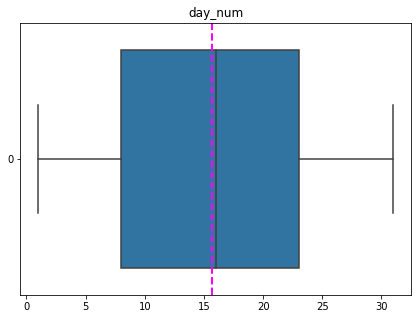

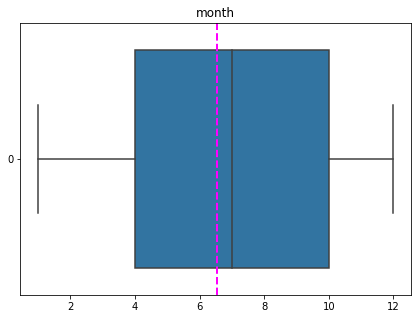

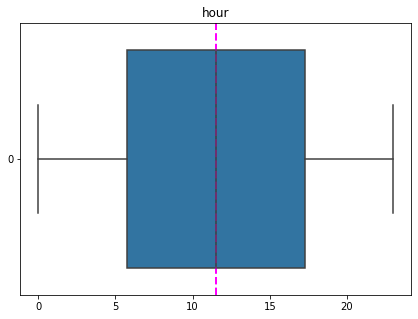

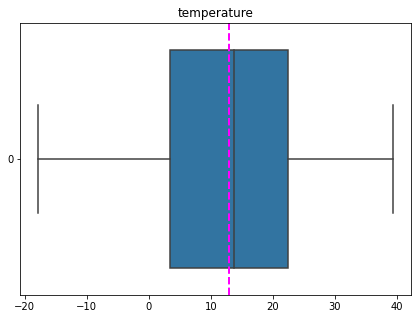

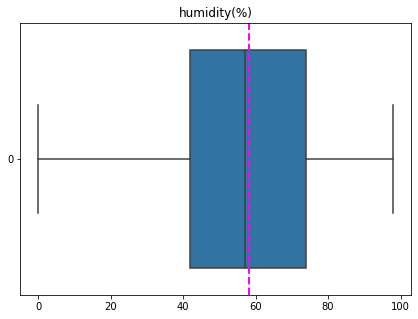

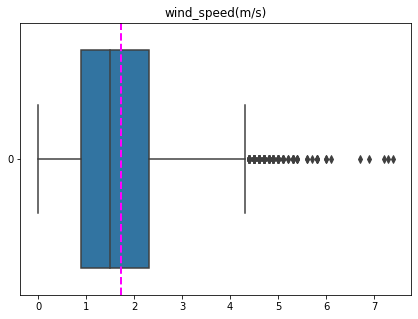

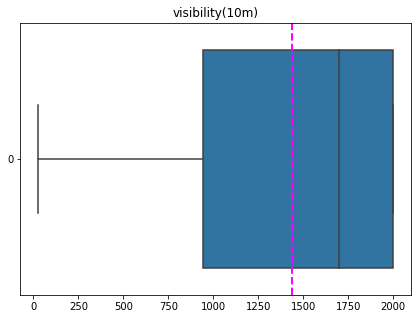

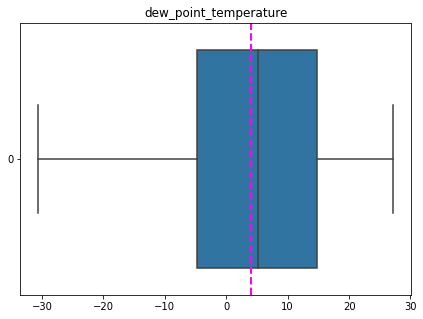

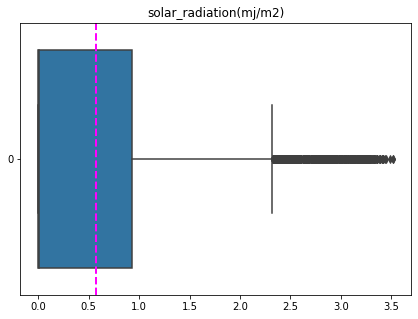

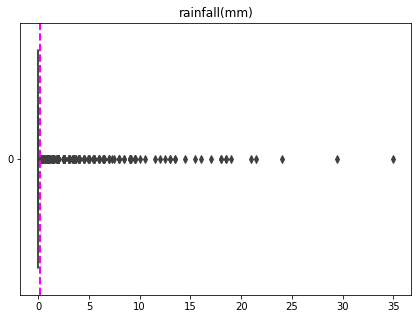

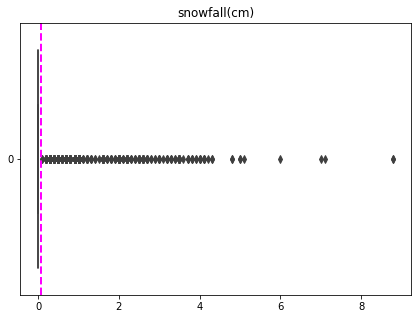

In [ ]:
# Checking for outliers
# Outliers - Windspeed, solar_radiation(mj/m2), rainfall(mm), snowfall(cm)

for col in numerical_features:
    fig = plt.figure(figsize=(7,5))
    ax = fig.gca()
    feature = df[col]
    sns.boxplot(data = feature, orient = 'h')
    # feature.hist(bins=50, ax = ax)
    ax.axvline(feature.mean(), color='magenta', linestyle='dashed', linewidth=2)
    # ax.axvline(feature.median(), color='cyan', linestyle='dashed', linewidth=2)    
    ax.set_title(col)
plt.show()



*   Rainfall and Snowfall have become irrelevant
*   Will drop and search for a fuzzy way to do this





In [ ]:
outliers = []
outliers.extend(['wind_speed(m/s)', 'snowfall(cm)', 'rainfall(mm)', 'solar_radiation(mj/m2)']
                )

outliers

['wind_speed(m/s)', 'snowfall(cm)', 'rainfall(mm)', 'solar_radiation(mj/m2)']

In [ ]:
df_copy = df.copy()

In [ ]:
def detect_outliers_iqr(data):
    data = sorted(data)
    q1 = np.percentile(data, 25)
    q3 = np.percentile(data, 75)
    # print(q1, q3)
    IQR = q3-q1
    lwr_bound = q1-(1.5*IQR)
    upr_bound = q3+(1.5*IQR)
    return (q1, q3, lwr_bound, upr_bound)




In [ ]:
for x in outliers:
  q1,q3, lwr_bound, upr_bound = detect_outliers_iqr(df_copy[x])
  df_copy.loc[df[x] < q1 , x] = lwr_bound
  df_copy.loc[df[x] > q3 , x] = upr_bound
 


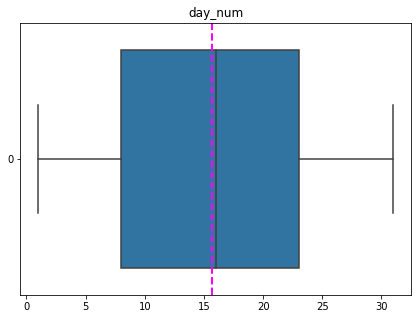

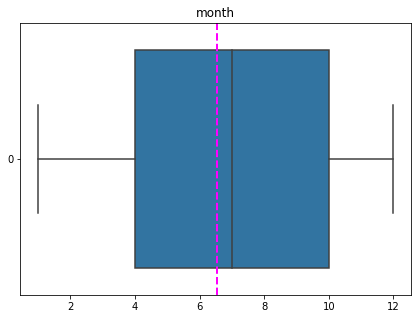

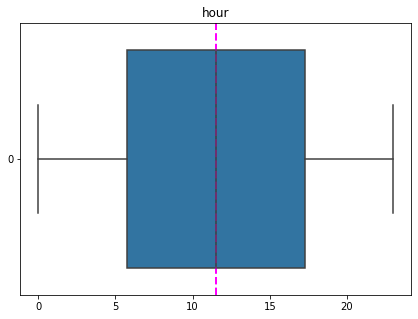

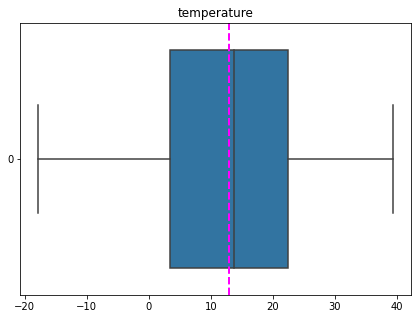

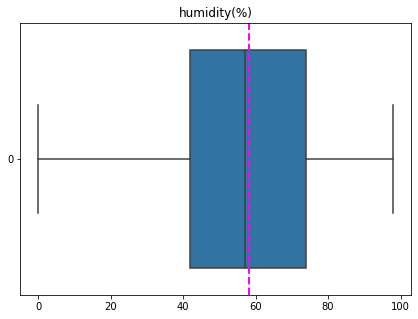

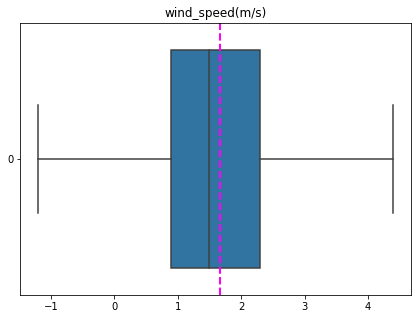

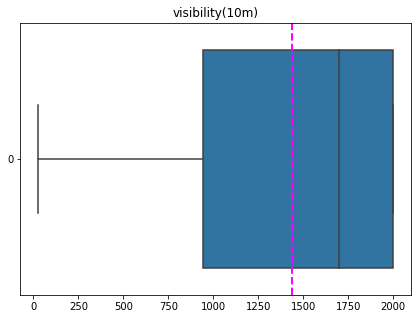

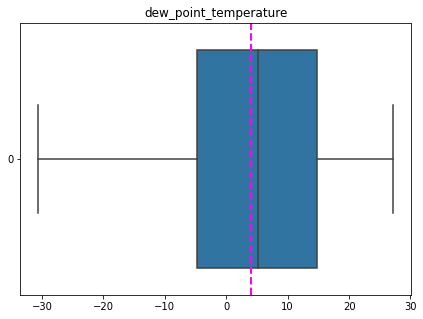

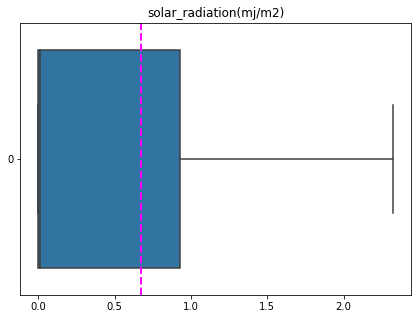

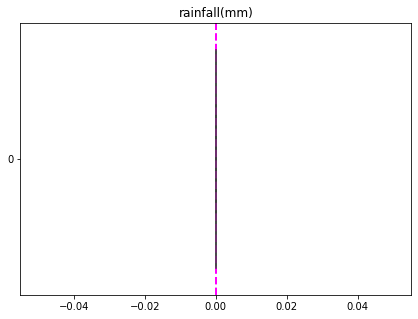

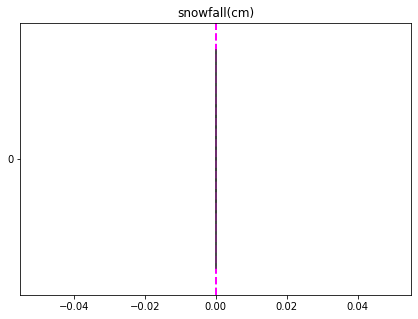

In [ ]:
for col in numerical_features:
    fig = plt.figure(figsize=(7,5))
    ax = fig.gca()
    feature = df_copy[col]
    sns.boxplot(data = feature, orient = 'h')
    # feature.hist(bins=50, ax = ax)
    ax.axvline(feature.mean(), color='magenta', linestyle='dashed', linewidth=2)
    # ax.axvline(feature.median(), color='cyan', linestyle='dashed', linewidth=2)    
    ax.set_title(col)
plt.show()


*   Rainfall and snowfall have become irrelevant
*   Will have to be dropped
*   List item





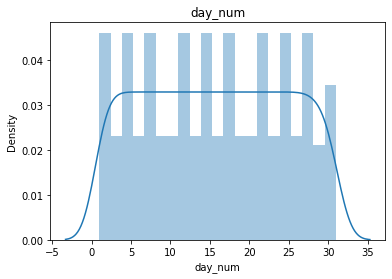

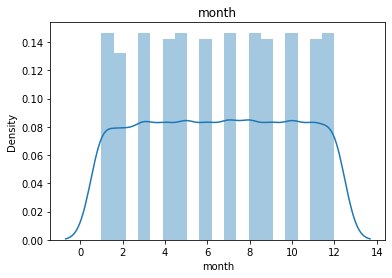

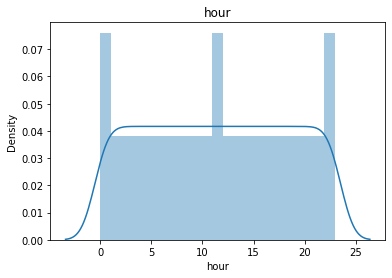

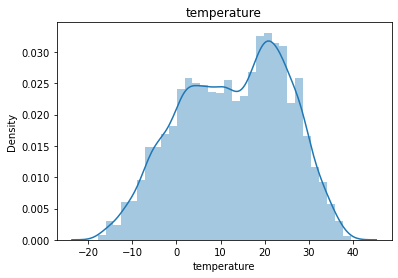

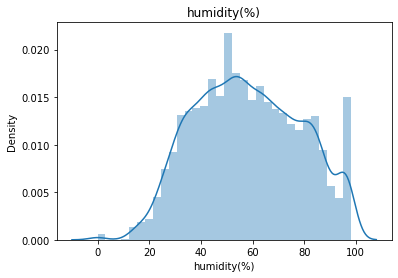

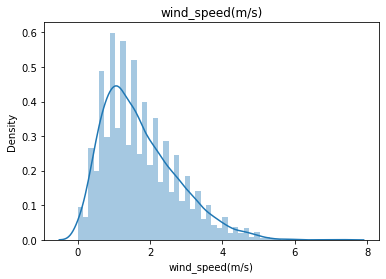

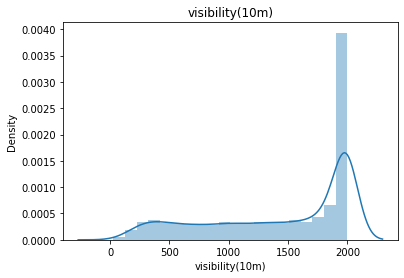

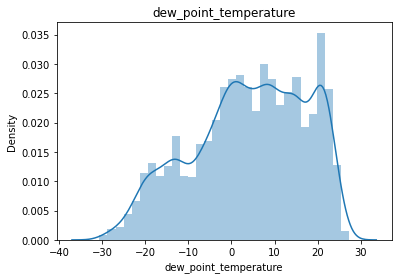

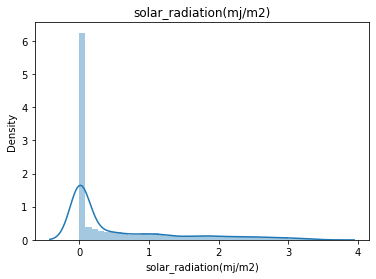

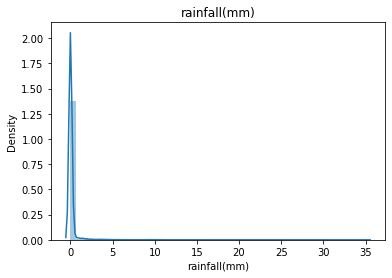

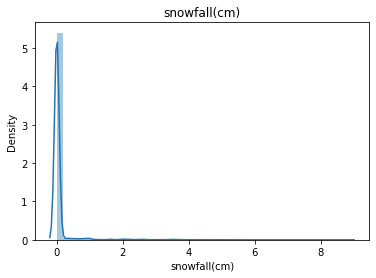

In [ ]:
# Check the distributions to be sure

for x in range(len(numerical_features)):
  
  plt.title(numerical_features[x])
  sns.distplot(a = df[numerical_features[x]])
  plt.show()



In [ ]:
df.isnull().sum()

date                      0
day_num                   0
month                     0
rented_bike_count         0
hour                      0
temperature               0
humidity(%)               0
wind_speed(m/s)           0
visibility(10m)           0
dew_point_temperature     0
solar_radiation(mj/m2)    0
rainfall(mm)              0
snowfall(cm)              0
seasons                   0
holiday                   0
functioning_day           0
dtype: int64

In [ ]:
df_copy.head()

,date,day_num,month,rented_bike_count,hour,temperature,humidity(%),wind_speed(m/s),visibility(10m),dew_point_temperature,solar_radiation(mj/m2),rainfall(mm),snowfall(cm),seasons,holiday,functioning_day
0,2017-12-01,1,12,254,0,-5.2,37,2.2,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
1,2017-12-01,1,12,204,1,-5.5,38,-1.2,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
2,2017-12-01,1,12,173,2,-6.0,39,1.0,2000,-17.7,0.0,0.0,0.0,Winter,No Holiday,Yes
3,2017-12-01,1,12,107,3,-6.2,40,0.9,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
4,2017-12-01,1,12,78,4,-6.0,36,2.3,2000,-18.6,0.0,0.0,0.0,Winter,No Holiday,Yes


In [ ]:
# Drop snowfall and rainfall features

df_copy.drop(['rainfall(mm)', 'snowfall(cm)'], axis = 1, inplace = True)

df_copy.head()

,date,day_num,month,rented_bike_count,hour,temperature,humidity(%),wind_speed(m/s),visibility(10m),dew_point_temperature,solar_radiation(mj/m2),seasons,holiday,functioning_day
0,2017-12-01,1,12,254,0,-5.2,37,2.2,2000,-17.6,0.0,Winter,No Holiday,Yes
1,2017-12-01,1,12,204,1,-5.5,38,-1.2,2000,-17.6,0.0,Winter,No Holiday,Yes
2,2017-12-01,1,12,173,2,-6.0,39,1.0,2000,-17.7,0.0,Winter,No Holiday,Yes
3,2017-12-01,1,12,107,3,-6.2,40,0.9,2000,-17.6,0.0,Winter,No Holiday,Yes
4,2017-12-01,1,12,78,4,-6.0,36,2.3,2000,-18.6,0.0,Winter,No Holiday,Yes


### **Model preparation**

In [ ]:
X = df_copy.copy()
X[target_variable] = X[target_variable] + 1
X = X.drop(['date'], axis = 1)
y = X.pop(target_variable)
X = pd.get_dummies(X, columns=categorical_features, prefix=["seasons", "holiday", "functioning_day"])

In [ ]:
from sklearn.preprocessing import StandardScaler

# define standard scaler
scaler_X = StandardScaler()
scaler_y = StandardScaler()

# transform data
X = scaler_X.fit_transform(X)


In [ ]:
y = np.log10(y)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)
print(X_train.shape)
print(X_test.shape)

(6570, 17)
(2190, 17)


In [ ]:
df['rented_bike_count'].sort_values()

In [ ]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()
reg = model.fit(X_train, y_train)

In [ ]:
reg.score(X_train, y_train)

0.7720198032928102

In [ ]:
reg.coef_

array([-2.00797474e-03,  3.41843235e-02,  1.17035640e-01, -1.98402321e-01,
       -3.57960728e-01, -2.81723930e-03, -4.56203254e-04,  4.80306249e-01,
        6.31013433e-03, -8.93549724e+11, -8.96804925e+11, -8.96804925e+11,
       -8.90246652e+11,  9.45850741e+10,  9.45850741e+10,  2.56669761e+10,
        2.56669761e+10])

In [ ]:
y_train_pred = reg.predict(X_train)

In [ ]:
y_pred = reg.predict(X_test)

In [ ]:
from sklearn.metrics import mean_squared_error

MSE  = mean_squared_error(10**(y_test), 10**(y_pred))
print("MSE :" , MSE)

RMSE = np.sqrt(MSE)
print("RMSE :" ,RMSE)

MSE : 228081.8330946048
RMSE : 477.5791380437433


In [ ]:
from sklearn.metrics import r2_score
r2 = r2_score(10**(y_test), 10**(y_pred))
print("R2 :" ,r2)
print("Adjusted R2 : ",1-(1-r2_score(10**(y_test), 10**(y_pred)))*((X_test.shape[0]-1)/(X_test.shape[0]-X_test.shape[1]-1)))

R2 : 0.47012571877817577
Adjusted R2 :  0.4659784523045243


In [ ]:
r2 = r2_score(10**(y_train), 10**(y_train_pred))
print("R2 :" ,r2)
print("Adjusted R2 : ",1-(1-r2_score(10**(y_train), 10**(y_train_pred)))*((X_test.shape[0]-1)/(X_test.shape[0]-X_test.shape[1]-1)))

R2 : 0.42626462825382705
Adjusted R2 :  0.42177406595194633
